In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
# import notebook_helper
import sys
import numpy as np
import imodelsx
import imodelsx.process_results
import sasc.data.data
from sasc.data.data import TASKS_D3
import warnings
import scipy.stats
def sem(x):
    '''Compute standard error of the mean, ignoring NaNs
    '''
    with warnings.catch_warnings():
        return scipy.stats.sem(x, ddof=0)
tqdm.pandas()
TASK_NAMES = list(TASKS_D3.keys())
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/mprompt/feb18_synthetic_sweep'
results_dir = '/home/chansingh/mntv1/mprompt/feb25'

In [ ]:
r = pd.read_pickle('../results/results_synthetic.pkl')

In [ ]:
# simplifying
default_params = {
    'noise_ngram_scores': 0,
    'module_num_restrict': -1,
}
rd = r
for k, v in default_params.items():
    rd = rd[rd[k] == v]

# Top results

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    d = (
        rd[[
            'task_keyword', 'top_explanation_init_strs',
            'top_contains_keywords',  # 'mean_contains_keywords',
            'top_score_synthetic', 'module_num', 'seed'
        ]]
        .rename(columns={
            'task_keyword': 'GT Explanation',
            'top_explanation_init_strs': 'Generated Explanation',
        })
    )
    d_ = d[d.top_contains_keywords == 0]
    slice_ = pd.IndexSlice[d_.index, d_.columns]

    # s = d.style
    display(
        d
        .style.hide()
        .set_properties(**{'background-color': '#132639'}, subset=slice_)
        .format(precision=2)
    )

# Details

**Selected examples**

In [ ]:
pos_examples = [(25, 2), (4, 1), (21, 1), (42, 1), (7, 1),
                (50, 1), (41, 1), (8, 1), (45, 1), (47, 1)]
neg_examples = [(18, 1), (26, 1), (39, 1), (2, 1)]

with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    tab = (
        pd.concat([rd[(rd.module_num == x[0]) & (rd.seed == x[1])]
                  for x in pos_examples + neg_examples])
        [[
            'task_keyword', 'top_explanation_init_strs',
        ]]
        .rename(columns={
                'task_keyword': 'Groundtruth Explanation',
                'top_explanation_init_strs': 'Generated Explanation',
                })
    )
    display(tab)
dummy = [''] * tab.shape[0]
dummy[0] = '\\parbox[c]{1mm}{\\multirow{' + \
    str(len(pos_examples)) + '}{*}{\\rotatebox[origin=c]{90} {Correct}}}'
dummy[len(pos_examples)] = '\\parbox[c]{1mm}{\\multirow{' + str(
    len(neg_examples)) + '}{*}{\\rotatebox[origin=c]{90} {Incorrect}}}'
tab.insert(0, ' ', dummy)
print(tab.style.hide(axis="index").to_latex(hrules=True).replace(
    'science \\\\', 'science \\\\ \n\midrule'))

**More details**

In [ ]:
# display full strings
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    display(
        rd
        .filter(['task_keyword', 'top_explanation_init_strs', 'top_contains_keywords', 'top_score_synthetic', 'module_num'])
        # .filter(['top_score_contains_keywords', 'top_score_synthetic', 'top_explanation_init_strs', 'explanation_init_ngrams', 'module_num'])
        # .filter(['top_explanation_init_strs', 'explanation_init_ngrams', 'top_strs_added'])
        # .filter(['explanation_init_strs', 'explanation_init_ngrams',])
        # .head(n=20)
    )

# Extra evaluation

### Export regexes

In [ ]:
from sasc.data.d3 import TASKS_D3

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 200):
    cols = {'index': 'Module name',
            'groundtruth_explanation': 'Dataset explanation', 'check_func': 'Regex check'}
    d = pd.DataFrame(TASKS_D3).T.reset_index()[
        cols.keys()].rename(columns=cols)
    d['Module name'] = d['Module name'].apply(
        lambda x: x.replace('d3_', '').replace('_', '-'))
    print(d.to_latex(index=False).replace('|', '$|$'))

### Analyze simiilaries with GT explanations

In [ ]:
rd1.columns

In [ ]:
rd1 = rd[rd.seed == 1]
rd1 = rd1[['top_explanation_init_strs', 'task_keyword',
           'task_name (groundtruth)', 'module_num']].sort_values(by='module_num')
rd1

In [ ]:
# generate similarity matrix of explanations and groundtruth texts using bge-large
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-large')
model = AutoModelForSequenceClassification.from_pretrained(
    'BAAI/bge-reranker-large')
model.eval()

In [44]:
texts_gen = rd1['top_explanation_init_strs'].values.tolist()
texts_gt = rd1['task_keyword'].values.tolist()
n = len(texts_gen)
pairs = []
for r in range(n):
    for c in range(n):
        pairs.append([texts_gen[r], texts_gt[c]])

# pairs = [pairs1[:3], pairs2[:3]]
# pairs = [['sarcasm', 'sarcasm'],
        #  ['sarcasm', 'unbiased']]
# pairs = [['what is panda?', 'hi'], ['what is panda?',
# 'The giant panda (Ailuropoda melanoleuca), sometimes called a panda bear or simply panda, is a bear species endemic to China.']]


with torch.no_grad():
    inputs = tokenizer(pairs, padding=True, truncation=True,
                       return_tensors='pt', max_length=512)
    scores = model(**inputs, return_dict=True).logits.view(-1, ).float()
    print(scores)

tensor([ 9.1713, -2.8577, -1.4306,  ..., -8.9529, -4.3623,  9.5176])


In [45]:
out = scores.reshape((n, n))

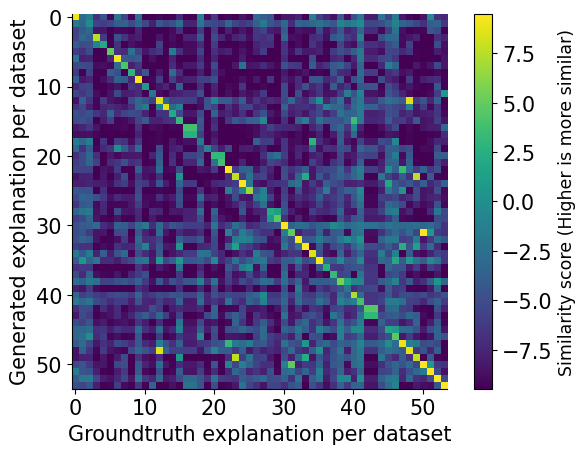

In [65]:
plt.imshow(out)
cb = plt.colorbar()
cb.set_label(label='Similarity score (Higher is more similar)', size='small')
plt.ylabel('Generated explanation per dataset')
plt.xlabel('Groundtruth explanation per dataset')
plt.tight_layout()
plt.savefig('synthetic_scores_sim_matrix.pdf', bbox_inches='tight')
plt.show()

In [93]:
# calculate top-k acc, accounting for ties
for k in [1, 2]:
    correct_count = 0
    for c in range(n):
        unique_vals = np.unique(out[:, c])[::-1]
        val_diag = out[c, c]
        if val_diag >= unique_vals[k - 1]:
            correct_count += 1
    print('top' + str(k) + '-acc', correct_count / n)

top1-acc 0.8148148148148148
top2-acc 0.8888888888888888
